# 처음부터 이미지 분류 (Image classification from scratch)

**저자:** [fchollet](https://twitter.com/fchollet)  
**생성일:** 2020/04/27  
**최종편집일:** 2023/11/09  
**설명:** Kaggle Cats vs Dogs 데이터세트를 사용하여 이미지 분류기를 처음부터 트레이닝합니다.

## 소개

이 예는 사전 트레이닝된 가중치나 미리 만들어진 Keras 애플리케이션 모델을 활용하지 않고, 디스크의 JPEG 이미지 파일에서 시작하여, 처음부터 이미지 분류를 수행하는 방법을 보여줍니다. Kaggle Cats vs Dogs 이진 분류 데이터 세트에 대한 워크플로우를 보여드립니다.

`image_dataset_from_directory` 유틸리티를 사용해 데이터 세트를 생성하고, 이미지 표준화 및 데이터 보강을 위해 Keras 이미지 전처리 레이어를 사용합니다.

셋업
-----

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [2]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

데이터 로드: Cats vs Dogs 데이터 세트
---------------------------------------


### Raw 데이터 다운로드

먼저, raw 데이터의 786M ZIP 아카이브를 다운로드해 보겠습니다:

In [7]:
!apt-get install -y aria2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libaria2-0 amd64 1.36.0-1 [1,086 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aria2 amd64 1.36.0-1 [381 kB]
Fetched 1,513 kB in 5s (297 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu

In [11]:
!aria2c -x 5 --summary-interval=10 https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


06/21 12:33:54 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Fri Jun 21 12:34:04 2024 *** 
=
[#b4a3d7 35MiB/786MiB(4%) CN:5 DL:3.7MiB ETA:3m20s]
FILE: /content/kagglecatsanddogs_5340.zip
-

 *** Download Progress Summary as of Fri Jun 21 12:34:15 2024 *** 
=
[#b4a3d7 87MiB/786MiB(11%) CN:5 DL:4.7MiB ETA:2m26s]
FILE: /content/kagglecatsanddogs_5340.zip
-

 *** Download Progress Summary as of Fri Jun 21 12:34:26 2024 *** 
=
[#b4a3d7 138MiB/786MiB(17%) CN:5 DL:4.7MiB ETA:2m17s]
FILE: /content/kagglecatsanddogs_5340.zip
-

 *** Download Progress Summary as of Fri Jun 21 12:34:37 2024 *** 
=
[#b4a3d7 190MiB/786MiB(24%) CN:5 DL:4.7MiB ETA:2m5s]
FILE: /content/kagglecatsanddogs_5340.zip
-

 *** Download Progress Summary as of Fri Jun 21 12:34:48 2024 *** 
=
[#b4a3d7 241MiB/786MiB(30%) CN:5 DL:4.7MiB ETA:1m55s]
FILE: /content/kagglecatsanddogs_5340.zip
-

 *** Download Progress Summary as of Fri Jun 21 12:34:59 2024 *** 
=
[#b4a3d7 293MiB/786MiB(37%) CN:5 DL:4.7MiB ETA:1

In [12]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 CDLA-Permissive-2.0.pdf      save_at_11.keras	 save_at_19.keras   save_at_2.keras
 downloads		      save_at_12.keras	 save_at_1.keras    save_at_3.keras
 kagglecatsanddogs_5340.zip   save_at_13.keras	 save_at_20.keras   save_at_4.keras
 model.png		      save_at_14.keras	 save_at_21.keras   save_at_5.keras
 PetImages		      save_at_15.keras	 save_at_22.keras   save_at_6.keras
'readme[1].txt'		      save_at_16.keras	 save_at_23.keras   save_at_7.keras
 sample_data		      save_at_17.keras	 save_at_24.keras   save_at_8.keras
 save_at_10.keras	      save_at_18.keras	 save_at_25.keras   save_at_9.keras


이제 `Cat`과 `Dog`라는 두 개의 하위 폴더가 있는 `PetImages` 폴더가 생겼습니다. 각 하위 폴더에는 각 카테고리에 대한 이미지 파일이 들어 있습니다.

In [13]:
!ls PetImages

Cat  Dog


### 손상된 이미지 필터링

많은 실제 이미지 데이터로 작업할 때, 손상된 이미지가 흔히 발생합니다. 헤더에 "JFIF" 문자열이 없는 잘못 인코딩된 이미지를 필터링해 보겠습니다.

In [14]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # 손상된 이미지 삭제
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.



`Dataset` 생성
--------------------

In [15]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


데이터 시각화
------------------

다음은 트레이닝 데이터 세트의 처음 9개 이미지입니다.

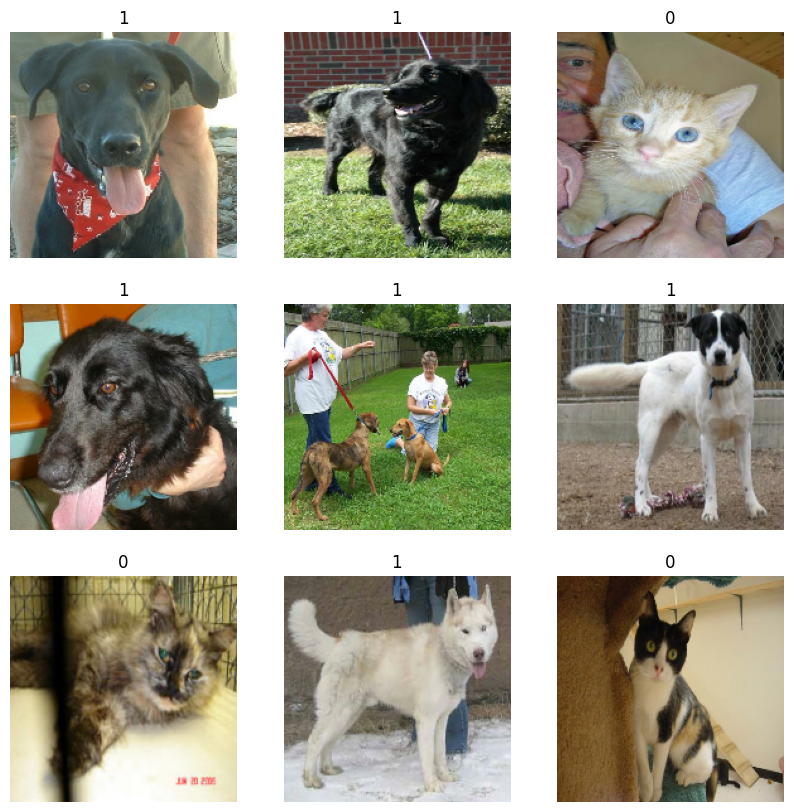

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

이미지 데이터 보강 사용
-----------------------------

이미지 데이터 세트가 크지 않은 경우, 무작위 수평 뒤집기나 작은 무작위 회전 등 트레이닝 이미지에 무작위적이지만 사실적인 변형을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다. 이렇게 하면 모델이 트레이닝 데이터의 다양한 측면에 노출되는 동시에, 과적합 속도를 늦추는 데 도움이 됩니다.

In [17]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

데이터 세트의 처음 몇 개의 이미지에 `data_augmentation`을 반복적으로 적용하여, 보강된 샘플이 어떻게 보이는지 시각화해 보겠습니다:

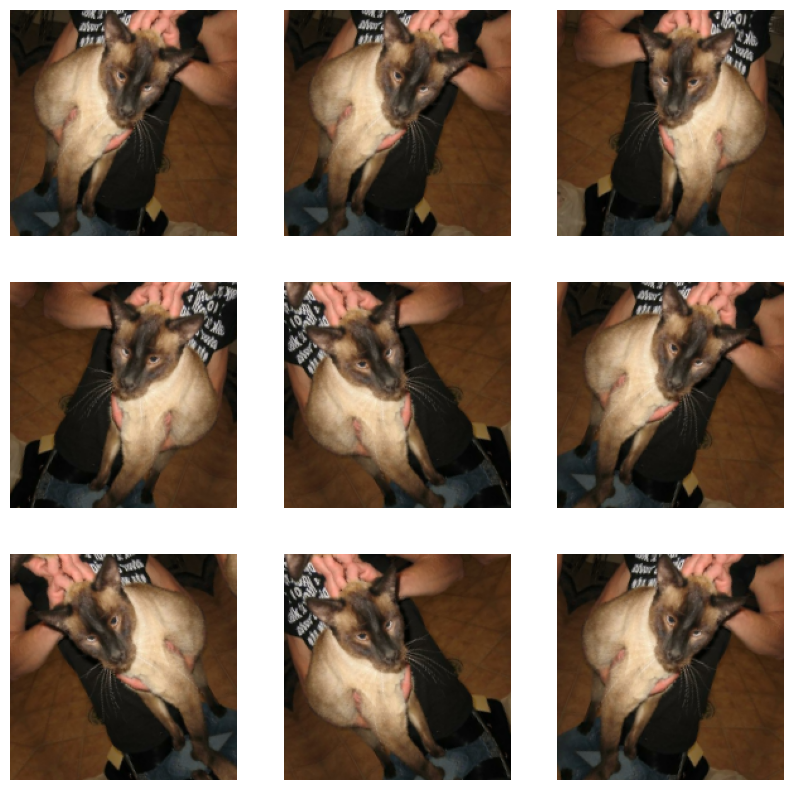

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

데이터 표준화
----------------------

이미지는 데이터 세트에 의해 연속적인 `float32` 배치로 산출되기 때문에, 이미 표준 크기(180x180)로 되어 있습니다. 그러나, RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이는 신경망에 이상적이지 않으며, 일반적으로 입력 값을 작게 만드는 것이 좋습니다. 여기서는 모델을 시작할 때 `Rescaling` 레이어를 사용하여, 값을 `[0, 1]` 범위로 표준화하겠습니다.

데이터 전처리를 위한 두 가지 옵션
----------------------------------

`data_augmentation` 전처리기를 사용하는 방법에는 두 가지가 있습니다:

**옵션 1: 모델의 일부로 만들기**. 다음과 같습니다.:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # 나머지 모델
```

이 옵션을 사용하면, 데이터 보강이 나머지 모델 실행과 동시에 _장치에서_ 발생하므로, GPU 가속의 이점을 누릴 수 있습니다.

데이터 보강은 테스트 시에는 비활성 상태이므로, 입력 샘플은 `evaluate()` 또는 `predict()`을 호출할 때가 아니라, `fit()` 중에만 보강된다는 점에 유의하세요.

GPU에서 트레이닝하는 경우, 이 옵션이 좋은 옵션일 수 있습니다.

**옵션 2: 데이터 세트에 적용**. 다음과 같이 보강된 이미지의 배치를 생성하는 데이터 세트를 얻습니다:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

이 옵션을 사용하면, 데이터 보강이 비동기적으로 **CPU**에서 이루어지며, 모델에 들어가기 전에 버퍼링됩니다.

CPU에서 트레이닝하는 경우, 이 옵션이 데이터 보강을 비동기식(asynchronous)으로 비차단적(non-blocking)으로 수행하므로, 더 나은 옵션입니다.

저희의 경우 두 번째 옵션을 사용하겠습니다. 어떤 것을 선택해야 할지 잘 모르겠다면, 두 번째 옵션(비동기 전처리)이 항상 확실한 선택입니다.

성능을 위한 데이터 세트 구성
-------------------------------------


트레이닝 데이터 세트에 데이터 보강을 적용하고, 버퍼링된 프리페칭(prefetching)을 사용하여 I/O가 차단(blocking)되지 않고, 디스크에서 데이터를 가져올 수 있도록 해 보겠습니다:

In [19]:
# 트레이닝 이미지에 `data_augmentation`을 적용
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# GPU 메모리에 샘플을 프리페칭(Prefetching)하면, GPU 활용도를 극대화할 수 있음.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

모델 구축
-------------

Xception 네트워크의 작은 버전을 구축하겠습니다. 아키텍처 최적화를 특별히 시도하지 않았으므로, 최적의 모델 구성을 체계적으로 검색하려면 [KerasTuner](https://github.com/keras-team/keras-tuner)를 사용하는 것이 좋습니다.

참고하세요:

* `data_augmentation` 전처리기로 모델을 시작한 다음, `Rescaling` 레이어를 추가합니다.
* 최종 분류 레이어 앞에 `Dropout` 레이어를 포함합니다.

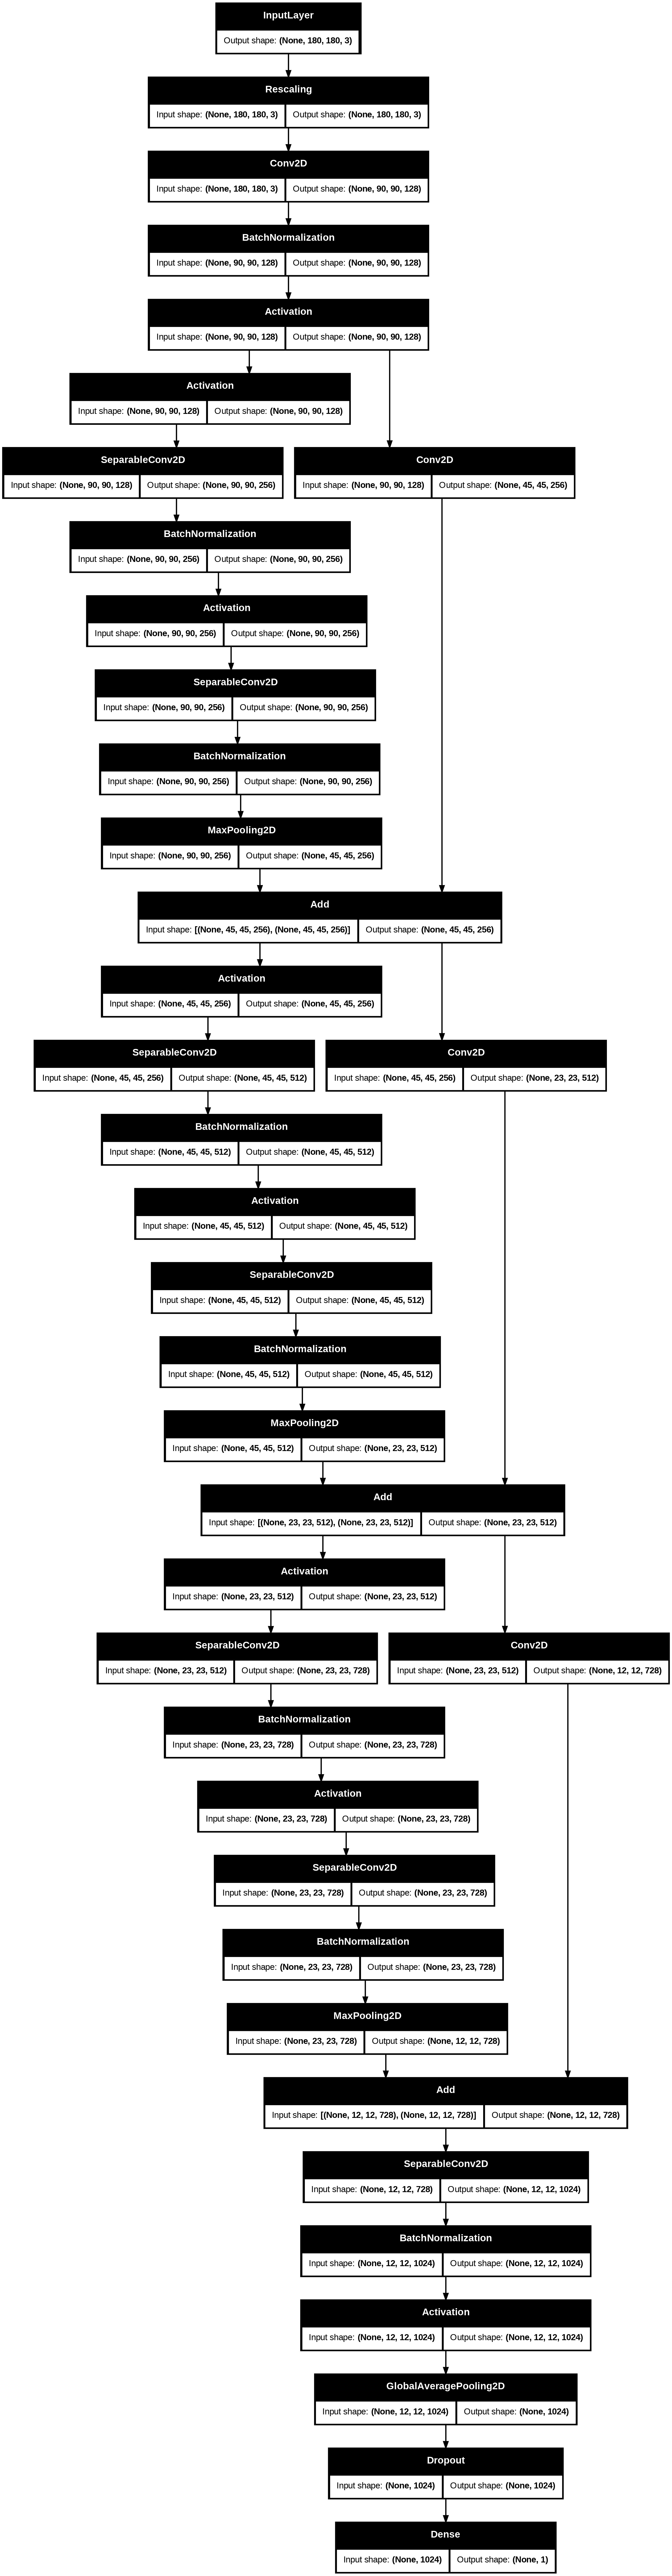

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # 엔트리 블록
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # 옆의 Residual을 설정

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Residual을 프로젝션
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Residual을 다시 더함
        previous_block_activation = x  # 다음 번의 옆의 Residual을 설정

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # logits를 반환하도록, `activation=None`으로 지정합니다.
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 180, 180, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 90, 90, 128)    │          3,584 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 90, 90, 128)    │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 90, 90, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 90, 90, 128)    │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 90, 90, 256)    │         34,176 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 90, 90, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 90, 90, 256)    │         68,096 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 90, 90, 256)    │          1,024 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 45, 45, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 45, 45, 256)    │         33,024 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 45, 45, 256)    │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 45, 45, 256)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 45, 45, 512)    │        133,888 │ activation_3[0][0]     │
│ (SeparableConv2D)    

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

모델 트레이닝
---------------

In [22]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 103s 363ms/step - acc: 0.6331 - loss: 0.6334 - val_acc: 0.4957 - val_loss: 0.6994
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.7520 - loss: 0.4901 - val_acc: 0.4957 - val_loss: 0.7023
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.8150 - loss: 0.3922 - val_acc: 0.4957 - val_loss: 0.6947
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.8449 - loss: 0.3311 - val_acc: 0.4957 - val_loss: 0.8416
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.8732 - loss: 0.2854 - val_acc: 0.7221 - val_loss: 0.4316
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.8904 - loss: 0.2518 - val_acc: 0.7499 - val_loss: 0.4370
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.9002 - loss: 0.2231 - val_acc: 0.8219 - val_loss: 0.5673
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - acc: 0.9150 - loss: 0.1967 - val_acc: 0.8857 - val_loss: 0.2285
Epoch 9/25
147/147 ━━━━━━━━━━━━

전체 데이터 세트에서 25 에포크에 대해 트레이닝한 후, 90% 이상의 검증 정확도를 달성했습니다. (실제로는 검증 성능이 저하되기 전에 50개 이상의 에포크에 대해 트레이닝할 수 있습니다)

새 데이터에 대한 추론 실행
-------------------------

추론 시에는 데이터 보강 및 드롭아웃이 비활성 상태입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
This image is 10.44% cat and 89.56% dog.


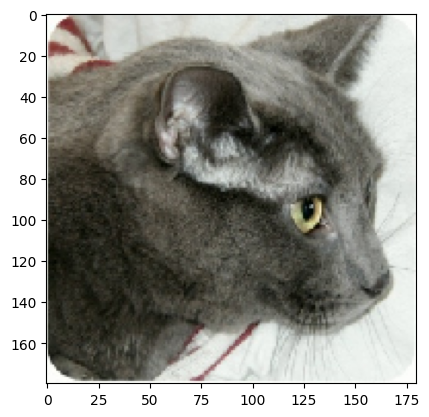

In [23]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # 배치 축 생성

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")